# Fraud Detection with Decision Tree CART on Cardzone dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

from matplotlib import style
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, accuracy_score, average_precision_score,  precision_recall_curve


# Data Collection and Investigation

__Import from SQL__ <br>
2 sample rule to indicate the fraud label
    1. High Risk Countries based on currency code
    2. Transaction that occured from midnight until 5am

__Currency Code__ <br>
971 - AFGHANISTAN <br>
643 - RUSSIAN <br>
586 - PAKISTAN

__SQL Statement__ <br>
UPDATE `cz_authtxn` <br>
SET `AUTHTXN_FRAUD_CHECK` = CASE <br>
&emsp; WHEN AUTHTXN_CURRENCY_CODE = 971 AND AUTHTXN_TRXN_TIME < 050000 THEN 'D' <br>
&emsp; WHEN AUTHTXN_CURRENCY_CODE = 643 AND AUTHTXN_TRXN_TIME < 050000 THEN 'D' <br>
&emsp; WHEN AUTHTXN_CURRENCY_CODE = 586 AND AUTHTXN_TRXN_TIME < 050000 THEN 'D' <br>
&emsp; ELSE 'F' <br>
END

In [ ]:
# Input data files are available in the "../input/" directory
df = pd.read_csv('D:/Python Project/Credit Card Fraud Detection/cardzone dataset/cz_authtxn.csv', skipinitialspace=True)
    
# print number of records in the dataset
print("Number of records:" , len(df))
print("Number of features:" , len(df.columns))

# check is there any null value in cells at columns
print("Number of features that has empty cells" , len(df.columns[df.isna().any()].tolist()))

df.columns[df.isna().any()].tolist()


In [ ]:
# Columns that have mixed type. But checked it is actually blank cells mixed

# print(df.columns.get_values()[17])
# print(df.columns.get_values()[21])
# print(df.columns.get_values()[88])
# print(df.columns.get_values()[89])
# print(df.columns.get_values()[104])
# print(df.columns.get_values()[136])
# print(df.columns.get_values()[137])
# print(df.columns.get_values()[166])
# print(df.columns.get_values()[182])

In [ ]:
# Checks how many fraud in this dataset
print(df['AUTHTXN_FRAUD_CHECK'].value_counts())

print('\nFraud is {}% of our data.'.format(df['AUTHTXN_FRAUD_CHECK'].value_counts()['D'] / float(df['AUTHTXN_FRAUD_CHECK'].value_counts()['F'])*100))


Conclusion = Imbalance. Learning of the data highly bias 

# Data Preprocessing
## Deal with missing values
There are several strategies to deal with missing data and there is no exact right answer
- A value from another randomly selected record.
- A mean, median or mode value for the column. (reduces variance in the dataset)
    - Categorical NaNs for mode
    - Numerical NaNs for mean
    - If there are outliers in Numerical, try median (less sensitive to them)
- Drop those record / column
- A value estimated by another predictive model.
- A distint constant value, such as 0 or -9999

However, missing values does not necessarily means to missing information. <br>
For example, if someone does not own a car, then of course it has no color resulting in missing value <br>
If replace the missing value with some other value might leads to wrong result

### Drop columns which has over 70% NaN values 
If a particular column has over 60% or 70% NaN values, it is better to drop it because it does not contributes towards giving information to ML model 
https://www.researchgate.net/publication/239608247_Machine_Learning_Based_Missing_Value_Imputation_Method_for_Clinical_Datasets

In [ ]:
# First, print out the exact 30% records number that i want to keep the column
print("Number of records that i want to keep in columns : ", len(df) * 0.3)

df.isna().mean().round(4) * 100

# Now, drop any columns that has 70% NaN
df.dropna(thresh=0.3*len(df), axis=1, inplace=True)

In [ ]:
# print list of columns after initial drop
print("The number of columns after initial dropping is ", len(df.columns))
print(df.columns)

# Recheck still got any left out blank cell in the columns that does not meet threshold
print("\nThe number of blank records in columns after initial dropping is ", len(df.columns[df.isna().any()]))
df.columns[df.isna().any()].tolist()


### Drop unnecessary columns according to prototype design document

In [ ]:
drop_columns = ['AUTHTXN_NO', 'AUTHTXN_CARDHOLDER_NAME', 'AUTHTXN_SYSTEM_ID', 'AUTHTXN_APPROVED_AMT', 'AUTHTXN_STAN',
                'AUTHTXN_PREV_STAN', 'AUTHTXN_TRANS_DATETIME', 'AUTHTXN_REQUEST_DATE', 'AUTHTXN_REQUEST_TIME', 'AUTHTXN_RESPONSE_DATE',
                'AUTHTXN_RESPONSE_TIME', 'AUTHTXN_SETTLED_DATE', 'AUTHTXN_LAST_UPDATE_DATE', 'AUTHTXN_LAST_UPDATE_TIME', 'AUTHTXN_CARD_EXPIRY_DATE',
                'AUTHTXN_POS_COND_CODE', 'AUTHTXN_RETRIEVAL_REFNO', 'AUTHTXN_OLD_RETRIEVAL_REFNO', 'AUTHTXN_APPROVAL_CODE', 'AUTHTXN_RESPONSE_CODE',
                'AUTHTXN_MERCHANT_NAME', 'AUTHTXN_SETTLED_IND', 'AUTHTXN_AUTO_EXPIRY_DATE', 'AUTHTXN_SUBSIDY_REBATE_AMT', 'AUTHTXN_MERC_MDR_AMT',
                'AUTHTXN_MERC_COMM_AMT', 'AUTHTXN_PROCESSEDBY', 'AUTHTXN_TYPE', 'AUTHTXN_INTERCHG_IND', 'AUTHTXN_GEOGRAPHY_IND',
                'AUTHTXN_BONUS','AUTHTXN_FEE', 'AUTHTXN_ACQ_CHARGE_AT_IND', 'AUTHTXN_POST_IND', 'AUTHTXN_COMPONENT_ID',
                'AUTHTXN_MTI', 'AUTHTXN_PROC_CD', 'AUTHTXN_BONUS_POINT', 'AUTHTXN_TERMBONUS_POINT', 'VERSION',
                'AUTHTXN_SUBSIDY_REBATE_QTY', 'AUTHTXN_STMT_INC_BONUS', 'AUTHTXN_STMT_INC_FEE', 'AUTHTXN_STMT_INC_COST', 'AUTHTXN_STMT_INC_COMM',
                'AUTHTXN_EBONUS', 'AUTHTXN_EFEE', 'AUTHTXN_SERVICE_CODE', 'AUTHTXN_ALT_RESPONSE_CODE', 'AUTHTXN_GST_AMT',
                'AUTHTXN_MERC_GST_AMT', 'AUTHTXN_VTXNTYPGRP_ID', 'AUTHTXN_EDC_SETTLED_IND', 'AUTHTXN_VS_TRXN_ID', 'AUTHTXN_MATCH_PREVTXN_IND',
                'AUTHTXN_ACQ_INST_ID', 'AUTHTXN_EDC_SETTLED_DATE', 'AUTHTXN_INTERBRANCH_IND', 'AUTHTXN_PIN_BASED', 'AUTHTXN_EXP_IND',
                'AUTHTXN_FOREX_MARKUP_AMT', 'AUTHTXN_EXCESS_AMT']

for col in drop_columns:
    df.drop(col, axis=1, inplace=True)

In [ ]:
print("The number of columns after second dropping is ", len(df.columns))
print(df.columns)

print("\nThe number of blank records in columns after second dropping is ", len(df.columns[df.isna().any()]))
df.columns[df.isna().any()].tolist()


In [ ]:
# print in a graphical way to visualize
import missingno as msno

msno.bar(df.sample(3000))


In [ ]:
# check unique values count in columns
df.nunique()

In [ ]:
# Drop columns if only have one unique value
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col,inplace=True,axis=1)

In [ ]:
print("After dropping columns which has only 1 unique values")
print("========================================================")
print("Number of records:" , len(df))
print("Number of features:" , len(df.columns))

In [ ]:
# Replace 0 to the missing values in colum
columns_nan_value = df.loc[:, df.isna().sum() > 0].columns

for i, col in enumerate(columns_nan_value):
    df[col].fillna(value = 0, inplace=True)

In [ ]:
# Recheck for any blank columns
df.isna().sum() > 0


### Convert date and time column to readable DateTime object
First, convert their types into String, then preprocess them as follows:
- For Dates which dont have year, assume it as 2018
- For Time(24-hour) which dont have Hours and Minutes infront, append the time with 00 : 00 : xx <br> Because of Excel automatically delete initial 0s infront, 

In [ ]:
df['AUTHTXN_TRXN_DATE'] = df['AUTHTXN_TRXN_DATE'].astype(str)
df['AUTHTXN_TRXN_TIME'] = df['AUTHTXN_TRXN_TIME'].astype(str)


In [ ]:
for i, date in enumerate(df.AUTHTXN_TRXN_DATE):
    if len(date) == 3:
        new_date = pd.datetime.strptime(date, '%m%d').date()
        new_date = new_date.replace(2018, 1)
        df.at[i, 'AUTHTXN_TRXN_DATE'] = new_date
    elif len(date) == 4:
        new_date = pd.datetime.strptime(date, '%m%d').date()
        new_date = new_date.replace(2018)
        df.at[i, 'AUTHTXN_TRXN_DATE'] = new_date
    elif len(date) == 8:
        new_date = pd.datetime.strptime(date, '%Y%m%d').date()
        df.at[i, 'AUTHTXN_TRXN_DATE'] = new_date


In [ ]:
for i, time in enumerate(df.AUTHTXN_TRXN_TIME):
    if len(time) == 1 or len(time) == 2:
        new_time = pd.datetime.strptime(time, '%S').time()
        df.at[i, 'AUTHTXN_TRXN_TIME'] = new_time
    elif len(time) == 3:
        time = str(0) + time
        new_time = pd.datetime.strptime(time, '%M%S').time()
        df.at[i, 'AUTHTXN_TRXN_TIME'] = new_time
    elif len(time) == 4:
        new_time = pd.datetime.strptime(time, '%M%S').time()
        df.at[i, 'AUTHTXN_TRXN_TIME'] = new_time
    elif len(time) == 5:
        time = str(0) + time
        new_time = pd.datetime.strptime(time, '%H%M%S').time()
        df.at[i, 'AUTHTXN_TRXN_TIME'] = new_time
    elif len(time) == 6:
        new_time = pd.datetime.strptime(time, '%H%M%S').time()
        df.at[i, 'AUTHTXN_TRXN_TIME'] = new_time
        

In [ ]:
df.AUTHTXN_TRXN_DATE = pd.to_datetime(df.AUTHTXN_TRXN_DATE)
df.AUTHTXN_TRXN_TIME = pd.to_datetime(df.AUTHTXN_TRXN_TIME, format='%H:%M:%S')

In [ ]:
pd.to_datetime(df.AUTHTXN_TRXN_TIME, format='%H:%M:%S').dt.hour.value_counts().sort_index().plot() 

### Enrich the dataset by extract additional features from the time values
A common step in "Feature Engineering" is parsing datetime into multiple values that might give additional information during ML. <br>
For example:
- Time of day (morning / afternoon / etc)
- Hour of the day
- What Year
- What month
- Day of Month (1-31)
- Day of the week (7)

From all these, you can infer 
- Is there any special events / holidays 
- Is the week where salary is out

In [ ]:
df["Year"] = pd.to_datetime(df.AUTHTXN_TRXN_DATE).dt.year
df["Month"] = pd.to_datetime(df.AUTHTXN_TRXN_DATE).dt.month
df["Day"] = pd.to_datetime(df.AUTHTXN_TRXN_DATE).dt.day
df["Day_of_week"] = pd.to_datetime(df.AUTHTXN_TRXN_DATE).dt.dayofweek
df["Hour"] = df.AUTHTXN_TRXN_TIME.dt.hour

hours = df['Hour']

# Period of time labeling
bins = [-1, 4, 8, 16, 20]
labels = ['Midnight', 'Morning','Afternoon','Evening','Night']
df['Period_of_time']  = np.array(labels)[np.array(bins).searchsorted(hours)-1]


In [ ]:
# Drop AUTHTXN_TRXN_DATE and AUTHTXN_TRXN_TIME as do not need anymore
df.drop(['AUTHTXN_TRXN_DATE'], axis=1, inplace=True)
df.drop(['AUTHTXN_TRXN_TIME'], axis=1, inplace=True)


In [ ]:
df.head()

### Label Encoding
Because of the columns contains string, it is better to convert them into continuous or categorical values before fitting into Decision Tree during fit <br>
For example, subject "Maths" to "0", "History" to "1", "Biology" to "2" and so on. 

In [ ]:
# first, map the D as 1, F as 0
df['AUTHTXN_FRAUD_CHECK'] = df['AUTHTXN_FRAUD_CHECK'].map({'F': 0, 'D': 1})


In [ ]:
# Replace the following types of columns to String, as it mixed with integer value
df['AUTHTXN_MERCHANT_ID'] = df['AUTHTXN_MERCHANT_ID'].astype(str)
df['AUTHTXN_TERMINAL_ID'] = df['AUTHTXN_TERMINAL_ID'].astype(str)
df['AUTHTXN_SOURCE_BIZMODE'] = df['AUTHTXN_SOURCE_BIZMODE'].astype(str)
df['AUTHTXN_DEST'] = df['AUTHTXN_DEST'].astype(str)
df['AUTHTXN_DEST_BIZMODE'] = df['AUTHTXN_DEST_BIZMODE'].astype(str)
df['AUTHTXN_TXN_ENTRY_MODE'] = df['AUTHTXN_TXN_ENTRY_MODE'].astype(str)
df['AUTHTXN_CNTRYGRP_ID'] = df['AUTHTXN_CNTRYGRP_ID'].astype(str)
df['AUTHTXN_ACQ_COMPONENT_ID'] = df['AUTHTXN_ACQ_COMPONENT_ID'].astype(str)
df['AUTHTXN_VCNTRYGRP_ID'] = df['AUTHTXN_VCNTRYGRP_ID'].astype(str)
df['AUTHTXN_VMCCGRP_ID'] = df['AUTHTXN_VMCCGRP_ID'].astype(str)

# As it is code, put it as category
df['AUTHTXN_COUNTRY_CODE'] = df['AUTHTXN_COUNTRY_CODE'].astype('category')
df["AUTHTXN_CURRENCY_CODE"] = df['AUTHTXN_CURRENCY_CODE'].astype('category')


In [ ]:
df.AUTHTXN_COUNTRY_CODE.unique()

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df['AUTHTXN_TXNTYPE_ID'] = label_encoder.fit_transform(df['AUTHTXN_TXNTYPE_ID'])
df['AUTHTXN_CARD_NO'] = label_encoder.fit_transform(df['AUTHTXN_CARD_NO'])
df['AUTHTXN_MERCHANT_ID'] = label_encoder.fit_transform(df['AUTHTXN_MERCHANT_ID'])
df['AUTHTXN_TERMINAL_ID'] = label_encoder.fit_transform(df['AUTHTXN_TERMINAL_ID'])
df['AUTHTXN_SOURCE_BIZMODE'] = label_encoder.fit_transform(df['AUTHTXN_SOURCE_BIZMODE'])
df['AUTHTXN_DEST'] = label_encoder.fit_transform(df['AUTHTXN_DEST'])
df['AUTHTXN_DEST_BIZMODE'] = label_encoder.fit_transform(df['AUTHTXN_DEST_BIZMODE']) 
df['AUTHTXN_CHARGE_AT_IND'] = label_encoder.fit_transform(df['AUTHTXN_CHARGE_AT_IND'])
df['AUTHTXN_CRDPLAN_ID'] = label_encoder.fit_transform(df['AUTHTXN_CRDPLAN_ID'])
df['MOD_USER'] = label_encoder.fit_transform(df['MOD_USER'])
df['AUTHTXN_TXN_ENTRY_MODE'] = label_encoder.fit_transform(df['AUTHTXN_TXN_ENTRY_MODE'])
df['AUTHTXN_CNTRYGRP_ID'] = label_encoder.fit_transform(df['AUTHTXN_CNTRYGRP_ID'])
df['AUTHTXN_ACQ_COMPONENT_ID'] = label_encoder.fit_transform(df['AUTHTXN_ACQ_COMPONENT_ID'])
df['AUTHTXN_VCNTRYGRP_ID'] = label_encoder.fit_transform(df['AUTHTXN_VCNTRYGRP_ID'])
df['AUTHTXN_VMCCGRP_ID'] = label_encoder.fit_transform(df['AUTHTXN_VMCCGRP_ID'])
df['AUTHTXN_CRDACCT_NO'] = label_encoder.fit_transform(df['AUTHTXN_CRDACCT_NO'])
df["AUTHTXN_POS_ENTRY_MODE"] = label_encoder.fit_transform(df['AUTHTXN_POS_ENTRY_MODE'])
df["AUTHTXN_MCC_ID"] = label_encoder.fit_transform(df['AUTHTXN_MCC_ID'])
df["AUTHTXN_CUST_ID"] = label_encoder.fit_transform(df['AUTHTXN_CUST_ID'])


In [ ]:
# Print label encoded value but because of refit, value changed
# print(list(df['Period_of_time'].unique()))
# print(list(label_encoder.inverse_transform(df['Period_of_time'].unique())))


In [ ]:
# Then now apply OneHotEncoder
# drop one column and make other category as baseline
# df = pd.get_dummies(df, columns=["Period_of_time", 'AUTHTXN_CURRENCY_CODE'], 
#                          drop_first = True)

df = pd.get_dummies(df, columns=["Period_of_time", 'AUTHTXN_CURRENCY_CODE'])


### Scaling
We need scaling because if the dispersion is too far away, one feature might over-weight the another feature when comparing and training. <br>
https://cdn-images-1.medium.com/max/1200/1*EyPd0sQxEXtTDSJgu72JNQ.jpeg

In [ ]:
# plot amount distribution
df['AUTHTXN_REQUEST_AMT'][-30:].plot(x='hour', figsize=(10,5), grid=True)
df['AUTHTXN_NET_AMT'][-30:].plot(x='hour', figsize=(10,5), grid=True)
plt.legend()

In [ ]:
# AUTHTXN_REQUEST_AMT
# AUTHTXN_NET_AMT
# AUTHTXN_BILLING_TXN_AMT

from sklearn.preprocessing import StandardScaler, MinMaxScaler

standard_scaler = StandardScaler()   
min_max_scaler = MinMaxScaler()

df['AUTHTXN_REQUEST_AMT'] = standard_scaler.fit_transform(df['AUTHTXN_REQUEST_AMT'].values.reshape(-1,1))
df['AUTHTXN_NET_AMT'] = standard_scaler.fit_transform(df['AUTHTXN_NET_AMT'].values.reshape(-1,1))
df['AUTHTXN_BILLING_TXN_AMT'] = standard_scaler.fit_transform(df['AUTHTXN_BILLING_TXN_AMT'].values.reshape(-1,1))


### Move AUTHTXN_FRAUD_CHECK as labels to last index for easy see

In [ ]:
fraud_label_df = df['AUTHTXN_FRAUD_CHECK'] 
df.pop('AUTHTXN_FRAUD_CHECK')
df['AUTHTXN_FRAUD_CHECK'] = fraud_label_df


In [ ]:
df.head()

### Export the new dataset

In [ ]:
df.to_csv(r'D:\Python Project\Credit Card Fraud Detection\cardzone dataset\preprocessed_data.csv', 
                            index=False)

# # Export fraud set only in xlsx extension
df.loc[df['AUTHTXN_FRAUD_CHECK'] == 'D'].to_excel(r'D:\Python Project\Credit Card Fraud Detection\cardzone dataset\fraud_set.xlsx', 
                                                index=False)

## Train Test Split

Now split the original dataset into train and test with stratify enable to target class.<br><br>
The purpose of stratify sampling is to __ensure that in each split must at least got one Fraud__ to counter the problem of higly skewed. <br>
For example, if there are 25% of fraud and 75% of non-fraud, stratify will make sure that your random split has 25% of fraud and 75% of non-fraud. <br>
Basically asking the model to take the training and test set such that the class proportion is same as of the whole datase
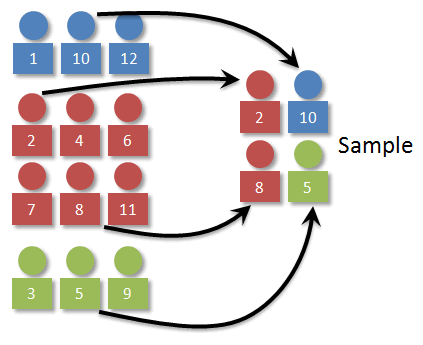

Random State aims to shuffle and split data randomly __and guarantee that the output of Split 1 will be equal to the output of Split 2__. <br>
__The order in which x_train and y_train will not be change__ <br>
__Used for reproducing problem the same every time it is run.__ <br>
Without random state, everytime run it , it will get a different ordering result <br>
0 or 42 is best practices
https://stackoverflow.com/questions/28064634/random-state-pseudo-random-numberin-scikit-learn

### Extract feature and target

In [ ]:
features = df.iloc[:, df.columns != 'AUTHTXN_FRAUD_CHECK']
target = df.iloc[:, df.columns == 'AUTHTXN_FRAUD_CHECK']


In [ ]:
from sklearn.model_selection import train_test_split
    
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42, stratify=target)

print("Total numbers of original dataset", len(x_train)+len(x_test))
print("Splited numbers of training dataset", len(x_train))
print("Splited numbers of testing dataset", len(x_test), "\n")

print("Training set")
print("==================")
print("Total number of legal transaction in training set", y_train['AUTHTXN_FRAUD_CHECK'].value_counts()[0])
print("Total number of fraud in training set", y_train['AUTHTXN_FRAUD_CHECK'].value_counts()[1])
print('Training set fraud is {}% \n'.format(y_train['AUTHTXN_FRAUD_CHECK'].value_counts()[1] / float(df['AUTHTXN_FRAUD_CHECK'].value_counts()[0])*100))

print("Testing set")
print("==================")
print("Total number of legal transaction in testing set", y_test['AUTHTXN_FRAUD_CHECK'].value_counts()[0])
print("Total number of fraud in testing set", y_test['AUTHTXN_FRAUD_CHECK'].value_counts()[1])
print('Testing set fraud is {}%'.format(y_test['AUTHTXN_FRAUD_CHECK'].value_counts()[1] / float(df['AUTHTXN_FRAUD_CHECK'].value_counts()[0])*100))


# Model Building
For this notebook / python, used Decision Tree CART as classifier model.


## Train the Model
Then we can now start evaluate prediction skill by using the testing set

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# To export as PMMl
# pipeline = PMMLPipeline([
#     ("classifier", DecisionTreeClassifier(random_state=42))
# ])

# pipeline.fit(x_train, y_train.values.ravel())

model = DecisionTreeClassifier(random_state=42)
model.fit(x_train, y_train.values.ravel())


In [ ]:
y_prediction = model.predict(x_test)

## Evaluating Classifier Performance

After train and fit, take a look at confusion matrix, which is a table that is often used to describe the performance of a classification model

1. __True Positives (TP)__
True positives are the cases when the actual class of the data point was 1(Fraud) and the predicted is also 1(Fraud)
<br>
2. __True Negatives (TN)__
True negatives are the cases when the actual class of the data point was 0(Legitimate) and the predicted is also 0(Legitimate)
<br>
3. __False Positives (FP)__
False positives are the cases when the actual class of the data point was 0(Legitimate) and the predicted is 1(Fraud). 
Because the model has predicted incorrectly as a positive (Fraud)
<br>
4. __False Negatives (FN)__
False negatives are the cases when the actual class of the data point was 1(Fraud) and the predicted is 0(Legitimate).
Because the model has predicted incorrectly as a negative (Legitimate)

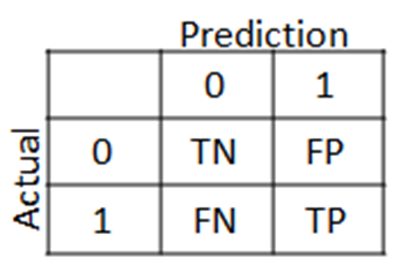

### Score Metrics Description
1. __Accuracy__ = Measure of how many correct predictions made by the model, fraud and not fraud 
2. __Precision__ = Measure of how many actual frauds caught compared to number of all returned results
3. __Recall__ = Measure of how many frauds caught compared to the number of actual frauds
4. __f1-score__ = Gives the harmonic mean of precision and recall.  2*(Recall * Precision) / (Recall + Precision)


In [ ]:
accuracy = accuracy_score(y_test, y_prediction) * 100
precison = precision_score(y_test, y_prediction) * 100
recall = recall_score(y_test, y_prediction) * 100
f1 = f1_score(y_test, y_prediction) * 100

print("Scores in %")
print("===============================")
print("Accuracy : ", accuracy)
print("Precison : ", precison)
print("Recall   : ", recall)
print("F1       : ", f1)


In [ ]:
from sklearn.metrics import classification_report, mean_absolute_error

print('---Classification Report---')
print(classification_report(y_test, y_prediction))

print("Model Mean Absolute Error {}".format(mean_absolute_error(y_test, y_prediction)))


In [ ]:
# Generate confusion matrix
cfm = confusion_matrix(y_test, y_prediction)
df_cm = pd.DataFrame(cfm, index = ['True (0)', 'True (1)'])
df_cm.columns = ['Predicted (0)', 'Predicted (1)']
sns.heatmap(df_cm, annot=True, fmt="d")

tn = cfm[0][0]
fp = cfm[0][1]
tp = cfm[1][1]
fn = cfm[1][0]


In [ ]:
# Use cross-validation to check over-fitting
from sklearn.model_selection import cross_val_score, StratifiedKFold

skf = StratifiedKFold(n_splits=10)

precision = cross_val_score(model, x_train, y_train, cv=skf, scoring='precision')
print("Precision: %0.2f (+/- %0.2f)" % (precision.mean(), precision.std()))


### Plot precision-recall curve
predict_proba is to calculate the posterior probability of the class label <br>
For example, if the probability of occurance of 0 is 0.237, then 1 is 0.762

In [ ]:
# Plot precision-recall curve
probas = model.predict_proba(x_test)[:,-1]
average_precision = average_precision_score(y_test, probas)
precision, recall, _ = precision_recall_curve(y_test, probas)

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))


### Plot the learning curve

In [ ]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Precision")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring ='precision')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


In [ ]:
title = "Learning Curves (Decision Tree CART)"
estimator = model
plot_learning_curve(estimator, title, features, target, cv=skf)

# Create a visualization for Decision Tree CART 

In [ ]:
import os
import pydotplus

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from collections import Counter

os.environ["PATH"] += os.pathsep + 'D:/Graphviz/bin'


In [ ]:
dot_data = StringIO()

export_graphviz(model, out_file=dot_data,
                feature_names = x_train.columns,
                filled=True, rounded=True,
                class_names=['F','D'],  
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

# feature_names = ["", ""]


## Quick rundown of the visualized tree
__Spitting criteria__: If the feature (Ex. V1) data lower than certain number, go to left, else go right<br>
__Gini__: Gini impurity of the node. It discribes how much the classes are mixed up.<br>
__Sample__: how many data is in the node<br>
__Value__: telling how many samples at that node fall into each category<br>
__Class__: the final label of the node


# Fine-tuning Decision Tree model

## Hyper-parameter tuning

To tune parameter, __K-fold cross validation__ is used. 5 fold is used, 10 fold is for small sample size

For this, we only consider maximum depth of the tree as other parameters are suitable. <br>
- __criterion__ : default=”gini”. (i. “gini” for the Gini impurity) (ii. “entropy” for the information gain.)
- __splitter__ :  “best” to choose the best split and “random” to choose the best random split.
- __max_depth__ : int or None, optional (default=None) If None, then nodes are expanded until all leaves are pure
- __min_samples_split__ : int, optional (default=2). Minimum number of samples required to split an internal node:
- __max_features__ : int, optional (default=None) The number of features to consider when looking for the best split:

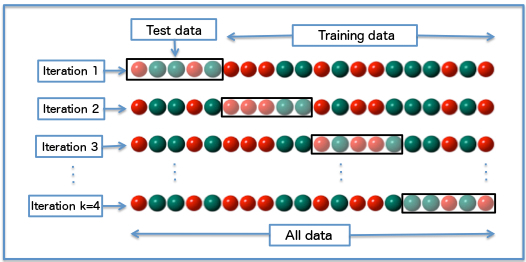

In [ ]:
# perform 10-fold cross validation, from range 3 to 6-1
max_depth = range(3, 6)
cv_scores = []

for depth in max_depth:
    print("Number of depth", depth)
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    scores = cross_val_score(model, x_train, y_train, cv=skf, scoring='precision')
    cv_scores.append(scores.mean())
    
print("Done")

In [ ]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_depth = max_depth[MSE.index(min(MSE))]
print('\nThe optimal number of depth is %d.' % optimal_depth)

In [ ]:
plt.plot(max_depth, cv_scores)
plt.xlabel('Number of depth')
plt.ylabel('Average Precision')

## Hyper-parameter tuning using Grid Search

A function __Grid Search__ is used to find best parameter between scores metrics <br>
In basic sense, it is a brute force method to estimate hyperparameters by test each and every combination
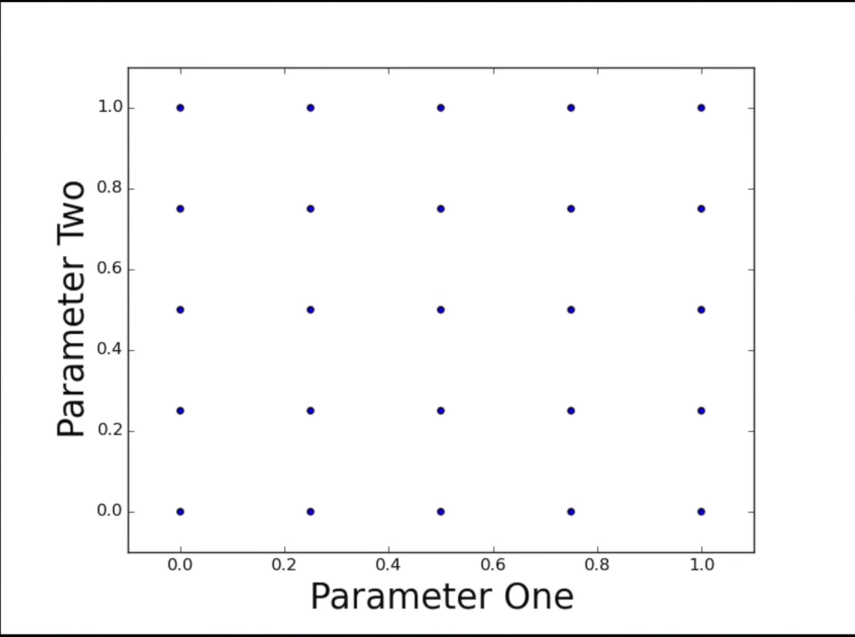

Just like Train Test Split, we will also use stratify method to ensure the distribution of fraud class is distributed across all folds
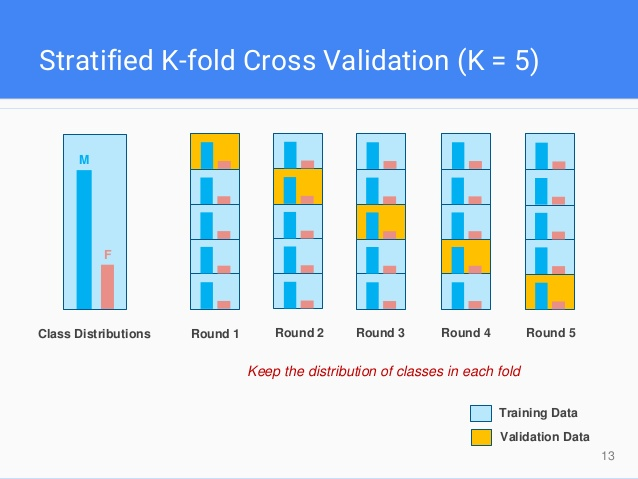

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import make_scorer

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

max_depth = np.arange(3,6)
min_samples_split = np.arange(2,50)

parameters = {'max_depth':max_depth, 'min_samples_split': min_samples_split}


In [ ]:
grid_search = GridSearchCV(model, parameters, scoring=scorers, refit='precision_score', 
                           cv=skf, return_train_score=True)

# gs = GridSearchCV(DecisionTreeClassifier(random_state=42),
#                   param_grid={'min_samples_split': range(2, 403, 10)},
#                   scoring=scorers, cv=5, refit='AUC', return_train_score=True)

grid_search.fit(x_train, y_train)


In [ ]:
print (grid_search.best_score_, grid_search.best_params_)
grid_search.best_estimator_


## RandomizedSearchCV

__Disadvantages of Grid Search__
- Can be computationally expensive, especially if you are searching over a large hyperparameter space, dealing with multiple hyperparameters and use many k-folds.
    - For example, 10-fold cross validation with Grid Search for 2 parameters
        - Max Depth = [3,4,5] (3)
        - Min Sample Splits = [2...49] (47)   
        So the Grid Search will try 3*47 = 141 * 10 folds = 1410 fits, which eats very long training and testing time

__RandomizedSearchCV__ is a "faster" of Grid Search, instead of brute-forcing every parameters, a fixed number of hyperparameter settings is randomly sample
- You search only a random subset of the provided parameter values

It's certainly possible that Randomized Search will not find as good a result as Grid Search because you just finding a random subset of the provided parameter values.  <br>
But it is often it finds the best result (or very close) in a fraction of the time that Grid Search would have resulted.
https://arxiv.org/ftp/arxiv/papers/1503/1503.06410.pdf


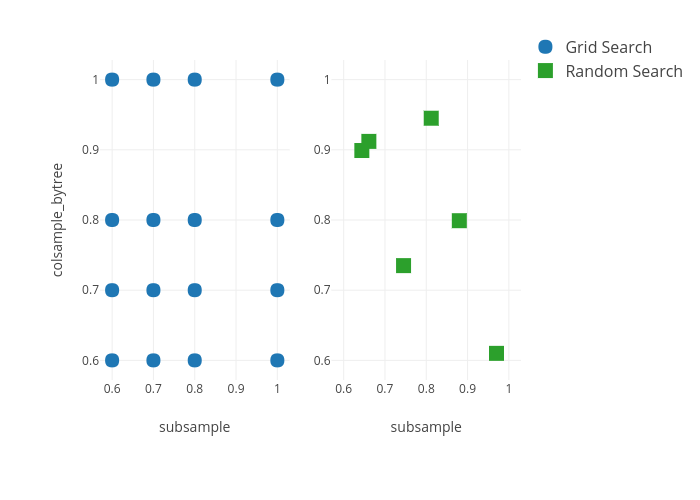
The randomized search and the grid search explore exactly the same space of parameters.


In [ ]:
random = RandomizedSearchCV(estimator = model, 
                            param_distributions = parameters,
                            scoring=scorers,  
                            refit='precision_score', 
                            cv=skf, 
                            n_iter = 10,
                            return_train_score=True)

random.fit(X = x_train, y = y_train)

In [ ]:
print (random.best_score_, random.best_params_)
random.best_estimator_


#### Retrain with best parameter

In [ ]:
model = random.best_estimator_
model.fit(x_train, y_train)

y_prediction = model.predict(x_test)


## Evaluating Fine-tuned Decision Tree model Performance

In [ ]:
accuracy = accuracy_score(y_test, y_prediction) * 100
precison = precision_score(y_test, y_prediction) * 100
recall = recall_score(y_test, y_prediction) * 100
f1 = f1_score(y_test, y_prediction) * 100

print("Scores in %")
print("===============================")
print("Accuracy : ", accuracy)
print("Precison : ", precison)
print("Recall   : ", recall)
print("F1       : ", f1)


In [ ]:
print('---Classification Report---')
print(classification_report(y_test, y_prediction))

print("Model Mean Absolute Error {}".format(mean_absolute_error(y_test, y_prediction)))


In [ ]:
# Generate confusion matrix
cfm = confusion_matrix(y_test, y_prediction)
df_cm = pd.DataFrame(cfm, index = ['True (0)', 'True (1)'])
df_cm.columns = ['Predicted (0)', 'Predicted (1)']
sns.heatmap(df_cm, annot=True, fmt="d")

tn = cfm[0][0]
fp = cfm[0][1]
tp = cfm[1][1]
fn = cfm[1][0]


In [ ]:
# Plot precision-recall curve
probas = model.predict_proba(x_test)[:,-1]
average_precision = average_precision_score(y_test, probas)
precision, recall, _ = precision_recall_curve(y_test, probas)

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))


In [ ]:
# Plot the learning curve
title = "Fined-tuned learning curves (Decision Tree CART)"
estimator = model
plot_learning_curve(estimator, title, features, target, cv=10)


In [ ]:
# Use cross-validation to check over-fitting
precision = cross_val_score(model, x_train, y_train, cv=skf, scoring='precision')
print("Precision: %0.2f (+/- %0.2f)" % (precision.mean(), precision.std() * 2))


# Create a visualization for fine-tuned Decision Tree model 

In [ ]:
dot_data = StringIO()

export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,
                feature_names = x_train.columns,
                class_names=['F','D'],  
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())


### Print decision rules

In [ ]:
from sklearn.tree import _tree
    
def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))
    print("# If else rules start here")

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            
            target = tree_.value[node]
            for i, v in zip(np.nonzero(target)[1],
                            target[np.nonzero(target)]):
                target_name = model.classes_[i]
                target_count = int(v)
                print("{}return ".format(indent) + str(target_name) + " ( " + str(target_count) + " examples )")
#             print("{}return {}".format(indent, tree_.value[node]))
    recurse(0, 1)

In [ ]:
tree_to_code(model, features.columns)

## Export the test set and test the prediction whether it is true or not

In [ ]:
test_set = pd.concat([x_test,y_test], axis=1)

In [ ]:
test_set.to_csv(r'test set.csv')

In [ ]:
# print the row to show out
# non-fraud
# pd.concat([x_test.iloc[:1],y_test.iloc[:1]], axis=1)

# fraud
pd.concat([x_test.iloc[4:5],y_test.iloc[4:5]], axis=1)

In [ ]:
x_test.iloc[4:5].to_string(header=False, index=False, index_names=False)

In [ ]:
model.predict(list(x_test.iloc[4:5].values))

# Export the model as joblib / Java / PMML file

In [ ]:
import joblib
joblib.dump(model, 'DecisionTreeClassifier.joblib')

In [ ]:
# load the model
decision_tree = joblib.load("DecisionTreeClassifier.joblib")

In [ ]:
decision_tree.predict(list(x_test.iloc[:1].values))

In [ ]:
from sklearn2pmml import sklearn2pmml

# with_repr: boolean, optional
# If true, insert the string representation of pipeline into the PMML document.

# debug: boolean, optional
# If true, print information about the conversion operation.
sklearn2pmml(pipeline, "DecisionTree.pmml", with_repr = True, debug = True)

In [ ]:
from sklearn_porter import Porter

porter = Porter(model, language='java')
output = porter.export()

# Embededd the if else rule data inside java class
# output = porter.export(embed_data=True)

# Export the if else rule data as json file
# output = porter.export(export_data=True)

print(output)

## Save classifier, then compile it using javac -cp . DecisionTreeClassifier.java

In [ ]:
with open('DecisionTreeClassifier.java', 'w') as f:
    f.write(output)

## Run classification

In [ ]:
# java -cp .:gson.jar DecisionTreeClassifier data.json 1 2 3 4